In [1]:
import numpy as np

def selu(x, alpha=3, scale=1):
    if isinstance(x, np.ndarray):
        return scale * np.where(x > 0, x, alpha * (np.exp(x) - 1))
    else:
        return scale * (x if x > 0 else alpha * (np.exp(x) - 1))

In [2]:
features = []
Xs = []
for i in range(1000):
    x = np.linspace(np.random.randint(-100,0), np.random.randint(0,101),100)
    Xs.append(x)
    feature = selu(x)
    features.append(feature)

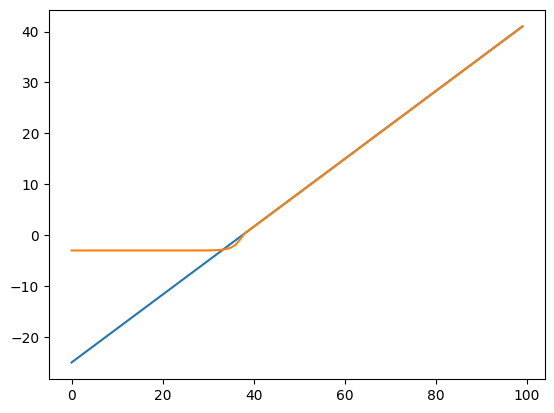

In [3]:
import matplotlib.pyplot as plt

plt.plot(Xs[0])
plt.plot(features[0])
plt.show()

In [4]:
Xs = np.asarray(Xs)
features = np.asarray(features)

print(features.shape,Xs.shape)

(1000, 100) (1000, 100)


In [5]:
import tensorflow as tf

# Definición del modelo
clasificador = tf.keras.models.Sequential([
    tf.keras.layers.Dense(len(features[0]), activation='relu', input_shape=[len(features[0])]),
    tf.keras.layers.Dense(len(features[0])*2, activation='selu'),
    tf.keras.layers.Dense(len(features[0])*4, activation='selu'),
    tf.keras.layers.Dense(len(features[0])*8, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

clasificador.summary()

2023-06-19 20:48:19.262198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 20:48:19.327340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 20:48:19.328211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 20:48:20.961573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 dense_3 (Dense)             (None, 800)               320800    
                                                                 
 dense_4 (Dense)             (None, 1)                 801       
                                                                 
Total params: 432,301
Trainable params: 432,301
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Definición del modelo
generador = tf.keras.models.Sequential([
    tf.keras.layers.Dense(len(features[0]), activation='linear', input_shape=[len(features[0])]),
    tf.keras.layers.Dense(len(features[0])*2, activation='linear'),
    tf.keras.layers.Dense(len(features[0])*4, activation='linear'),
    tf.keras.layers.Dense(len(features[0])*8, activation='linear'),
    tf.keras.layers.Dense(len(features[0]), activation='linear')
])

clasificador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     


                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 dense_3 (Dense)             (None, 800)               320800    
                                                                 
 dense_4 (Dense)             (None, 1)                 801       
                                                                 
Total params: 432,301
Trainable params: 432,301
Non-trainable params: 0
_________________________________________________________________


In [7]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def clasificadorLoss(real_out,fake_out):
    realLoss = crossEntropy(tf.ones_like(real_out),real_out)
    fakeLoss = crossEntropy(tf.zeros_like(fake_out),fake_out)
    return realLoss+fakeLoss

In [9]:
def generadorLoss(fake_out):
    return crossEntropy(tf.ones_like(fake_out),fake_out)

In [10]:
generadorOp = tf.keras.optimizers.Adam(1e-3)
clasificadorOp = tf.keras.optimizers.Adam(1e-3)

In [11]:
genH = []
clasH = []

def guardarPerdida(genLoss,clasLoss):
    genH.append(genLoss)
    clasH.append(clasLoss)

In [12]:
@tf.function
def trainStep(features):
    with tf.GradientTape() as genTape, tf.GradientTape() as clasTape:
        X = []
        for i in range(tf.shape(features)[0]):
            x = np.linspace(np.random.randint(-100,0), np.random.randint(0,101),100)
            X.append(x)
        X = np.asarray(X)
        prediccion = generador(X,training=True)
        
        real = clasificador(features,training=True)
        falsa = clasificador(prediccion,training=True)

        perdidaGen = generadorLoss(falsa)
        perdidaClas = clasificadorLoss(real,falsa)

        genGrad = genTape.gradient(perdidaGen,generador.trainable_variables)
        clasGrad = clasTape.gradient(perdidaClas,clasificador.trainable_variables)

        generadorOp.apply_gradients(zip(genGrad,generador.trainable_variables))
        clasificadorOp.apply_gradients(zip(clasGrad,clasificador.trainable_variables))

        tf.py_function(lambda gen_loss, clas_loss: print(f"genLoss: {gen_loss}, clasLoss: {clas_loss}"),
                   [perdidaGen, perdidaClas], [])

    return perdidaGen, perdidaClas

In [13]:
def train(features,epocas):
    for e in range(epocas):
        perdidaGen, perdidaClas = trainStep(features)
        guardarPerdida(perdidaGen,perdidaClas)
        print("epoca:",e+1)

        

In [28]:
epocas = 9000
train(features,epocas)

genLoss: 3.313434600830078, clasLoss: 0.1203937903046608
epoca: 1
genLoss: 3.634787082672119, clasLoss: 0.19554392993450165
epoca: 2
genLoss: 3.361037492752075, clasLoss: 0.2592219412326813
epoca: 3
genLoss: 2.5408339500427246, clasLoss: 0.2890762686729431
epoca: 4
genLoss: 2.0540292263031006, clasLoss: 0.28810131549835205
epoca: 5
genLoss: 1.7679136991500854, clasLoss: 0.2880181670188904
epoca: 6
genLoss: 2.4105513095855713, clasLoss: 0.1742478609085083
epoca: 7
genLoss: 2.5509254932403564, clasLoss: 0.14469096064567566
epoca: 8
genLoss: 2.2909481525421143, clasLoss: 0.15708112716674805
epoca: 9
genLoss: 2.403620719909668, clasLoss: 0.14078423380851746
epoca: 10
genLoss: 2.9550981521606445, clasLoss: 0.10112710297107697
epoca: 11
genLoss: 3.565657138824463, clasLoss: 0.07587593048810959
epoca: 12
genLoss: 3.8520724773406982, clasLoss: 0.061822082847356796
epoca: 13
genLoss: 3.591643810272217, clasLoss: 0.05850911885499954
epoca: 14
genLoss: 3.072736978530884, clasLoss: 0.0699946731328

In [29]:
prediccion = generador.predict(Xs)

32/32 [==============================] - 0s 4ms/step


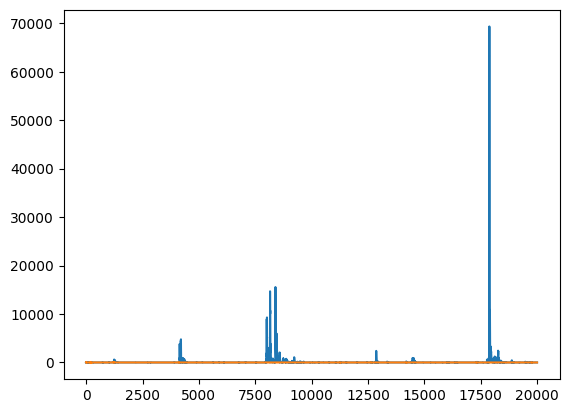

In [30]:
genH_values = np.array(genH)
clasH_values = np.array(clasH)

plt.plot(genH_values)
plt.plot(clasH_values)
plt.show()

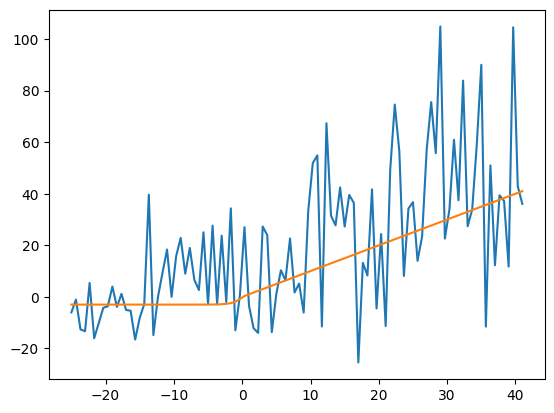

In [35]:
plt.plot(Xs[0],prediccion[0])
plt.plot(Xs[0],features[0])
plt.show()

In [37]:
generador.save("red/generador")
clasificador.save("red/clasificador")

INFO:tensorflow:Assets written to: red/generador/assets
INFO:tensorflow:Assets written to: red/clasificador/assets
